In [43]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## 1. Load Data

In [44]:
input_path = Path("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/attention_speech_len.parquet")
df = pd.read_parquet(input_path)

top_words_path = Path("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/unique_top_words.parquet")
words_df = pd.read_parquet(top_words_path)

df.head()

,year,decade,month,reference_date,chamber,title,topic,debate_id,speaker,gender,observed_words,observed_turns,expected_words_gender,norm_words_speaker,expected_words_flat,flat_norm_words,avg_words_per_turn,expected_avg_words_per_turn,norm_avg_words_per_turn,group_norm_words
0,1991,1990,apr,19 April 1991,Commons,"SMOKE DETECTORS BILL (Hansard, 19 April 1991)",SMOKE DETECTORS BILL,000107eaaea6ea47,MR. COHEN,M,18,1.0,18.0,1.000000,18.0,1.000000,18.000000,18.00,1.000000,NaN
1,1991,1990,apr,19 April 1991,Commons,"SMOKE DETECTORS BILL (Hansard, 19 April 1991)",SMOKE DETECTORS BILL,000107eaaea6ea47,None,M,18,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1915,1910,mar,02 March 1915,Commons,CLAUSE 1.—(Right of British Subject Charged wi...,CLAUSE 1.—(Right of British Subject Charged wi...,0003c24378d0bbfd,MR. HOGGE,M,135,1.0,169.0,0.798817,84.5,1.597633,135.000000,42.25,3.195266,NaN
3,1915,1910,mar,02 March 1915,Commons,CLAUSE 1.—(Right of British Subject Charged wi...,CLAUSE 1.—(Right of British Subject Charged wi...,0003c24378d0bbfd,MR. TENNANT,M,34,3.0,169.0,0.201183,84.5,0.402367,11.333333,42.25,0.268245,NaN
4,1915,1910,mar,02 March 1915,Commons,CLAUSE 1.—(Right of British Subject Charged wi...,CLAUSE 1.—(Right of British Subject Charged wi...,0003c24378d0bbfd,None,M,169,NaN,169.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [45]:
speaker_df = df[df["speaker"].notna()].copy()
group_df = df[df["speaker"].isna()].copy()

## 2. Basic Checks

In [46]:
print(speaker_df.shape)
print(speaker_df["gender"].value_counts())

(22759, 20)
gender
M    22395
F      364
Name: count, dtype: int64


## 3. Speaker-Level Normalization

### 3.1 Distribution of Normalized Words by Gender

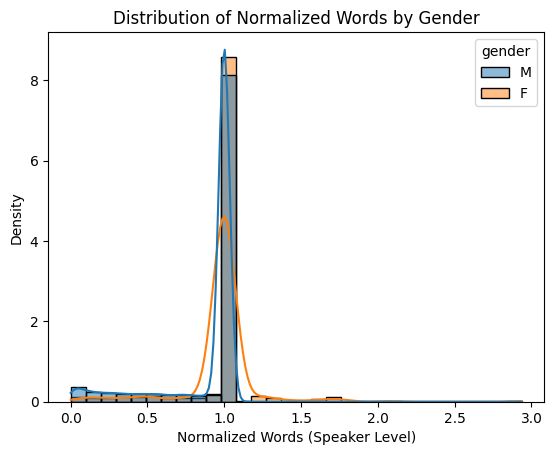

In [47]:
sns.histplot(
    data=speaker_df[speaker_df["norm_words_speaker"] < 3],  # example cap
    x="norm_words_speaker",
    hue="gender",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Distribution of Normalized Words by Gender")
plt.xlabel("Normalized Words (Speaker Level)")
plt.ylabel("Density")
plt.show()

### 3.2 Speaker-level Normalized Word Share by Gender

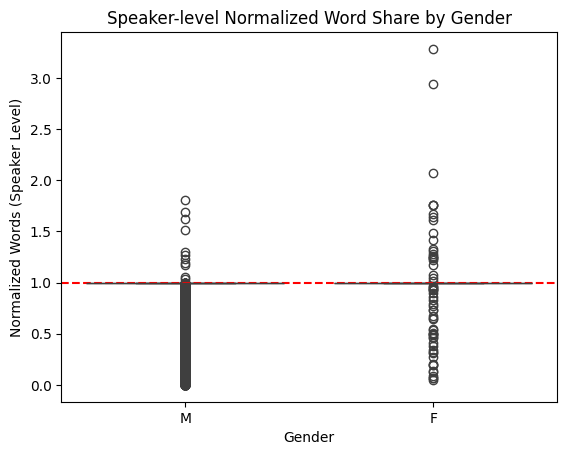

In [48]:
sns.boxplot(x="gender", y="norm_words_speaker", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Speaker-level Normalized Word Share by Gender")
plt.xlabel("Gender")
plt.ylabel("Normalized Words (Speaker Level)")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

### 3.3 Share of words over time (speaker-level mean)

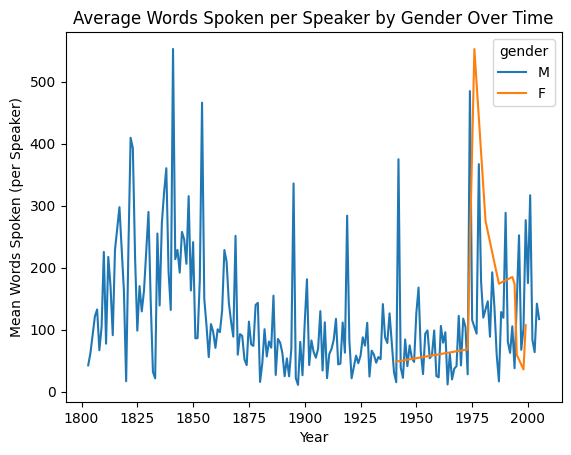

In [59]:
if "year" in speaker_df.columns:
    df_yearly_speaker = (
        speaker_df.groupby(["year", "gender"])["observed_words"]
        .mean()
        .reset_index()
    )

    sns.lineplot(x="year", y="observed_words", hue="gender", data=df_yearly_speaker)
    plt.title("Average Words Spoken per Speaker by Gender Over Time")
    plt.xlabel("Year")
    plt.ylabel("Mean Words Spoken (per Speaker)")
    plt.show()

### 3.4 Average Normalized Turns by Gender

/var/folders/0m/grfzmmms0559g5xz0whbn8180000gn/T/ipykernel_38720/2143486240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_gender, x="gender", y="norm_words_speaker", palette="pastel")
/var/folders/0m/grfzmmms0559g5xz0whbn8180000gn/T/ipykernel_38720/2143486240.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


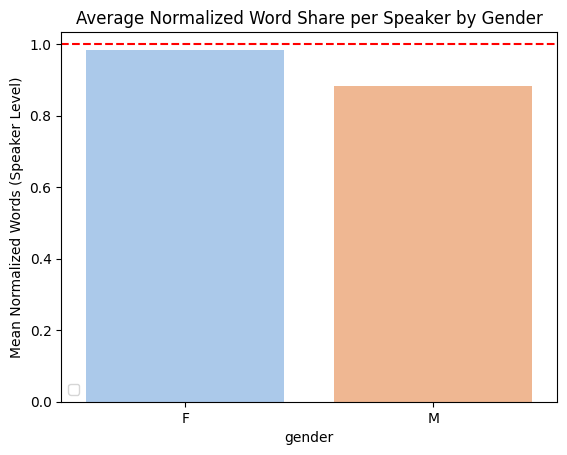

In [61]:
avg_by_gender = speaker_df.groupby("gender")["norm_words_speaker"].mean().reset_index()

sns.barplot(data=avg_by_gender, x="gender", y="norm_words_speaker", palette="pastel")
plt.title("Average Normalized Word Share per Speaker by Gender")
plt.ylabel("Mean Normalized Words (Speaker Level)")
plt.axhline(1, color="red", linestyle="--")
plt.legend()
plt.show()

## 4. Group-Level Normalization

### 4.1 Group-level Normalized Word Share by Gender

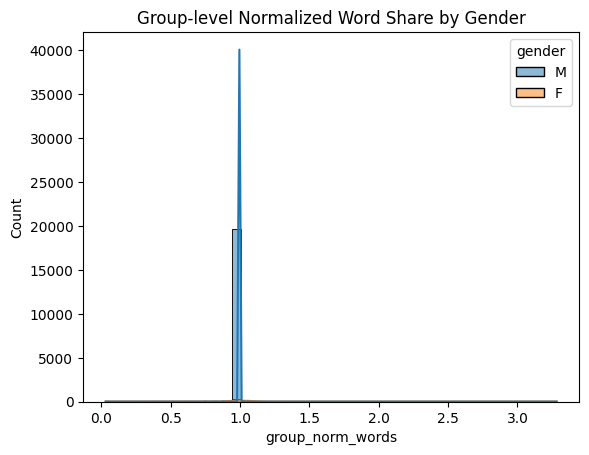

In [51]:
sns.histplot(data=group_df, x="group_norm_words", hue="gender", bins=50, kde=True)
plt.title("Group-level Normalized Word Share by Gender")
plt.show()

### 4.2 Share of words over time (group-level, aggregate)

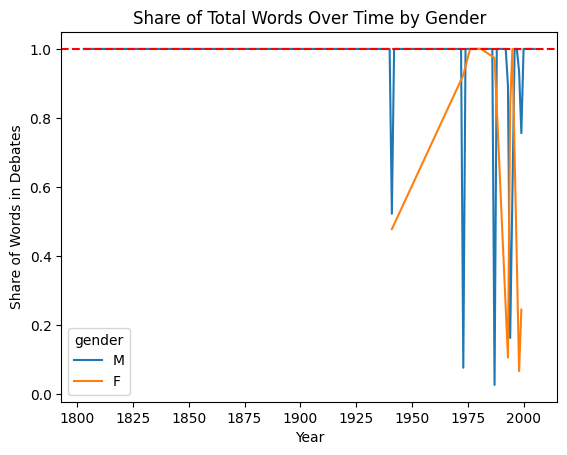

In [52]:
if "year" in group_df.columns:
    df_yearly = (group_df.groupby(["year", "gender"])["observed_words"].sum().reset_index())
    total_by_year = df_yearly.groupby("year")["observed_words"].transform("sum")
    df_yearly["share"] = df_yearly["observed_words"] / total_by_year

    sns.lineplot(x="year", y="share", hue="gender", data=df_yearly)
    plt.title("Share of Total Words Over Time by Gender")
    plt.xlabel("Year")
    plt.ylabel("Share of Words in Debates")
    plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
    plt.show()

### 4.3 Total observed words by gender

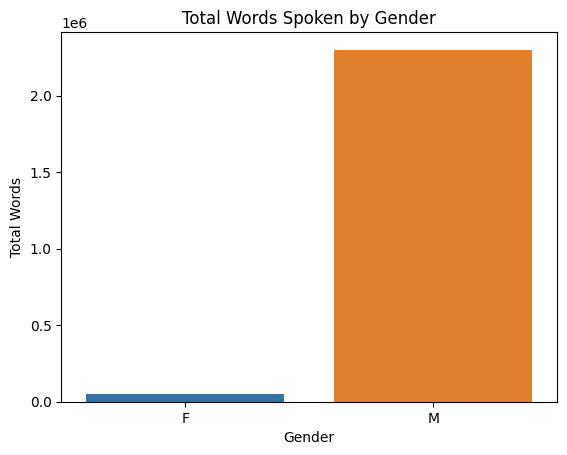

In [53]:
words_by_gender = group_df.groupby("gender")["observed_words"].sum().reset_index()

sns.barplot(x="gender", y="observed_words", hue='gender', data=words_by_gender)
plt.title("Total Words Spoken by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Words")
plt.show()

## 5. Flat Normalization

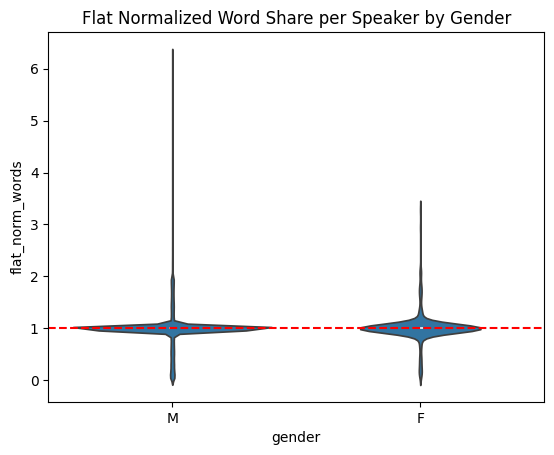

In [54]:
sns.violinplot(x="gender", y="flat_norm_words", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Flat Normalized Word Share per Speaker by Gender")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

## 6. Average Words per Turn

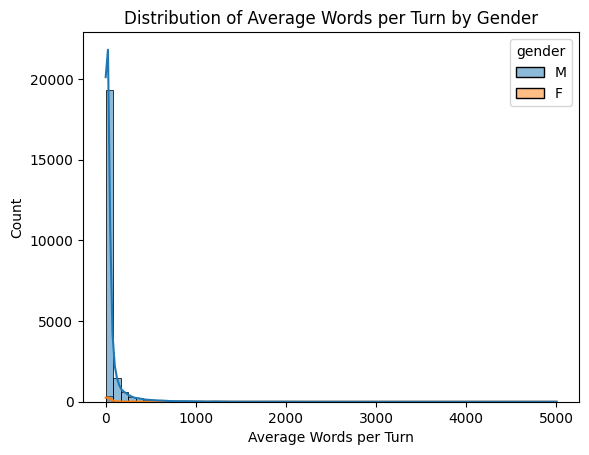

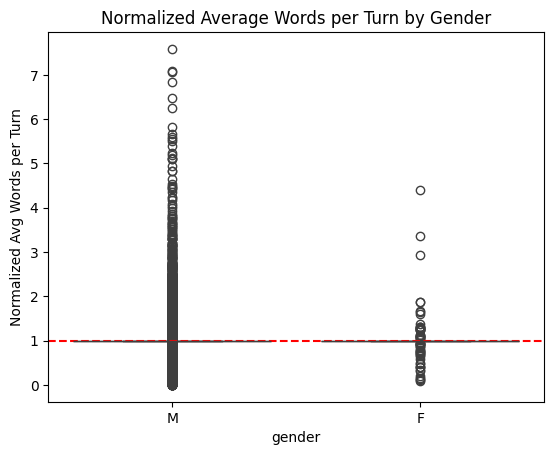

In [62]:
sns.histplot(data=speaker_df[speaker_df["speaker"].notna()], x="avg_words_per_turn", hue="gender", kde=True, bins=60)
plt.title("Distribution of Average Words per Turn by Gender")
plt.xlabel("Average Words per Turn")
plt.show()


sns.boxplot(x="gender", y="norm_avg_words_per_turn", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Normalized Average Words per Turn by Gender")
plt.ylabel("Normalized Avg Words per Turn")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

## 7. Distinctive Vocabulary

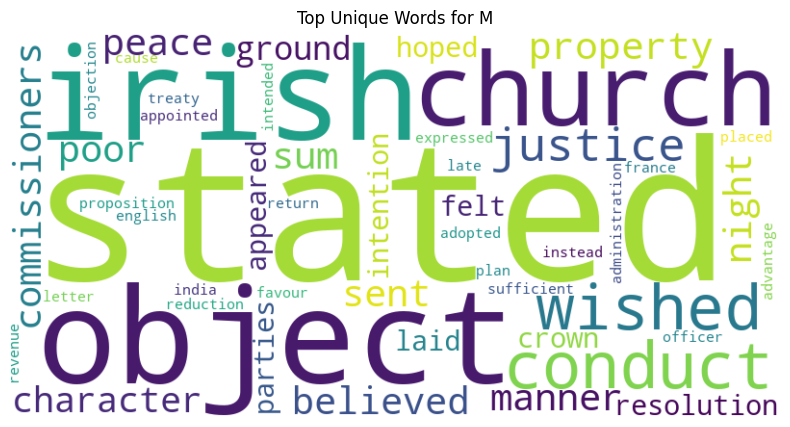

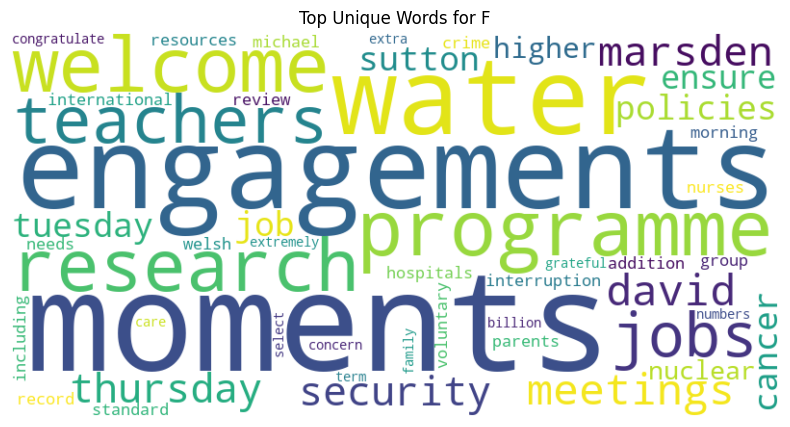

In [56]:
# If you have a dict of unique words saved separately:
try:
    for gender in ["M", "F"]:
        subset = words_df[words_df["gender"] == gender]
        if subset.empty:
            continue

        words_dict = dict(zip(subset["word"], subset["count"]))
        wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words_dict)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Top Unique Words for {gender}")
        plt.show()

except Exception as e:
    print("Unique word cloud section skipped:", e)

## 8. Comparison: Turns vs Words

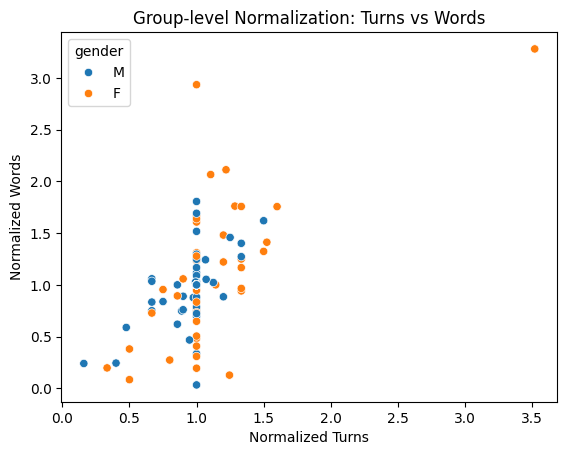

In [57]:
# If you have turn_frequency parquet for comparison:
try:
    turns_df = pd.read_parquet("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/attention_turn_freq_group.parquet")
    merged = pd.merge(df, turns_df, on=["debate_id", "gender"], suffixes=("_words", "_turns"))


    sns.scatterplot(x="group_norm_turns", y="group_norm_words", hue="gender", data=merged)
    plt.title("Group-level Normalization: Turns vs Words")
    plt.xlabel("Normalized Turns")
    plt.ylabel("Normalized Words")
    plt.show()
except Exception as e:
    print("Turn-word comparison skipped:", e)

## 9. Save Processed Data

In [58]:
# output_path = "processed_word_analysis.parquet"
# df.to_parquet(output_path, index=False)
# print(f"Processed data saved to {output_path}")